# Question 1: Theoretical Background

**Q1.1:** Object detection is the a computer vision technique that allows us to identify and locate objects in an image or a video. This is done by tracking the position of the object in the image, and then labelling these objects with identifiable labels.

**Q1.2:** The inputs in object detection are images (from which objects need to be detected), and annotation files for necessary image information (such as labels, bounding box, width, height of image). Since object detection requires a training and test data, the inputs are divided in these categories as well, and hence images and annotations are also divided into training and test categories. The outputs in object detection model are predicted bounding boxes and labels for each object in the given set of input images.

**Q1.3:** Image recognition refers to the computer vision technique which detects only one out of many objects present in an image. In object detection, all the different objects present in the image are detected and labelled.

**Q1.4:** Single stage detectors are based on regression techniques. They take input image, extract features to locate and label objects, and learn the class probabilities and bounding box coordinates. YOLO and SSD are examples of single stage detectors.

**Q1.5:** Two stage detectors perform object detection in two stages. First, they divide the input image into different regions of interest using a region proposal network. Next, a classification network is applied on these regions of interest to determine the label, and bounding boxes for the objects in the image are determined.



# Question 2: Implementation of RCNN

**Q2.1:** Accessing the PASCAL_VOC Dataset

In [1]:
!gdown https://drive.google.com/uc?id=1xgk7svdjBiEyzyUVoZrCz4PP6dSjVL8S

Downloading...
From: https://drive.google.com/uc?id=1xgk7svdjBiEyzyUVoZrCz4PP6dSjVL8S
To: /content/pascal_20_detection.zip
1.93GB [00:16, 120MB/s]


**Q2.2:** Unzipping data and Analysis of Dataset

As visualized in the code blocks below, this dataset contains images from 4 main categories; animals, vehicles, human beings, and indoor items. These 4 main categories can be further subdivided into categories such as aeroplanes, bus, boat, bird, cat, cow, TV etc. Thus, the combined total of all categories (including subcategories) is 20. The dataset is also provided with annotation files which describes the categories of the objects in images for training phase. If there are multiple objects in an image, then the annotation file will contain the information related to bounding box and class labels for all objects in the image. This dataset has been widely used as a benchmark for object detection tasks. The loaded dataset has 17125 annotated images.

In [2]:
#Create new directory for dataset
!mkdir PASCAL_VOC/

In [3]:
#Unzip data 
import shutil
shutil.unpack_archive("/content/pascal_20_detection.zip", "/content/PASCAL_VOC")

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data = ImageDataGenerator(rescale=1./255)

data_generator = data.flow_from_directory(
        '/content/PASCAL_VOC',
        target_size=(64, 64),
        batch_size=128,
        class_mode='binary')

Found 17125 images belonging to 1 classes.


In [5]:
images, _ = next(iter(data_generator))
images.shape

(128, 64, 64, 3)

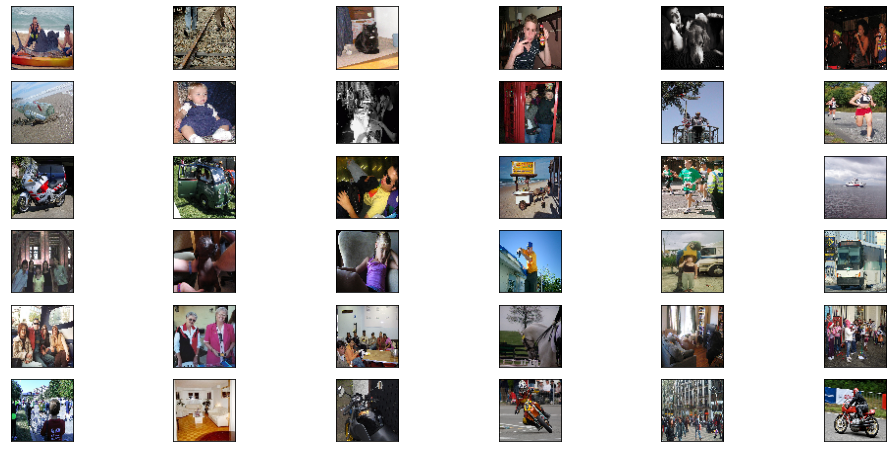

In [8]:
# Visualizing the dataset

import matplotlib.pyplot as plt

#Displaying some samples of the data
fig, axes = plt.subplots(ncols=6, nrows=6, figsize=(17, 8))
index = 0
for i in range(6):
  for j in range(6):
    axes[i,j].imshow(images[index])
    axes[i,j].get_xaxis().set_visible(False)
    axes[i,j].get_yaxis().set_visible(False)
    index += 1
plt.show()

**Q2.3:** Initializing selective search

In [6]:
import cv2
selective_search = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

**Q2.4:** Implementing function for calculating Intersection over Union

In [8]:
def get_IOU(box1, box2):
  x1 = max(box1[0], box2[0])
  y1 = max(box1[1], box2[1])
  x2 = min(box1[2], box2[2])
  y2 = min(box1[3], box2[3])
 
  interArea = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
  box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
  box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
  
  iou = interArea/(box1_area + box2_area - interArea)
  
  return iou

**Q2.5:** Data pre-processing

In [ ]:
import os 
from bs4 import BeautifulSoup

images_dir = '/content/PASCAL_VOC/pascal_20_detection/imgs/'
annotations_dir = '/content/PASCAL_VOC/pascal_20_detection/anns/'

labels = []

for i, annot in enumerate(os.listdir(annotations_dir)):
  filename = annot.split(".")[0] +".jpg"
  image = cv2.imread(images_dir + filename)

	# load the annotation file, and extract ground truth boxes
  contents = open(annotations_dir + annot).read()
  soup = BeautifulSoup(contents, "html.parser")
  gtBoxes = []
  w = int(soup.find("width").string)
  h = int(soup.find("height").string)
	
  for o in soup.find_all("object"):
    label = o.find("name").string
    labels.append(label)
    x_min = int(o.find("xmin").string)
    y_min = int(o.find("ymin").string)
    x_max = int(o.find("xmax").string)
    y_max = int(o.find("ymax").string)

    x_min = max(0, x_min)
    y_min = max(0, y_min)
    x_max = max(w, x_max)
    y_max = max(h, y_max)
    
    gtBoxes.append((x_min, y_min, x_max, y_max))
  
  selective_search.setBaseImage(image)
  selective_search.switchToSelectiveSearchFast()
  ssresults = selective_search.process()

  pos_counter = 0
  max_positive_roi = 30
  neg_counter = 0
  max_negative_roi = 30
  train_images = []

  for i, ssbox in enumerate (ssresults):
    (x, y, w, h) = ssbox
    for gtBox in gtBoxes:
      (gx, gy, gw, gh) = gtBox
      iou = get_IOU(gtBox, ssbox)
      if iou > 0.7 and pos_counter < max_positive_roi:
        roi = image[y:h, x:w]
        resized = cv2.resize(roi, (32,32), interpolation = cv2.INTER_CUBIC)
        train_images.append(resized)
        pos_counter += 1

      elif iou < 0.3 and neg_counter < max_negative_roi:
        roi = image[y:h, x:w]
        resized = cv2.resize(image, (32,32), interpolation = cv2.INTER_CUBIC)
        train_images.append(resized)
        neg_counter += 1
    break

**Q2.6:** Preparing the network. An existing architecture (VGG-16) was used with Imagenet weights and the model was fine tuned.

In [10]:
from keras.layers import Dense
from keras import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.losses import categorical_crossentropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

vgg = VGG16(weights="imagenet", include_top=True)

553476096/553467096 [==============================] - 5s 0us/step


In [11]:
#freezing first 15 layers
for i in vgg.layers[:15]:
  i.trainable = False

#transforming vgg16 to add 20 units of Dense layer because we have 20 classes to predict
out = vgg.layers[-20].output
predictions = Dense(20, activation="softmax")(out)
model = Model(vgg.input, predictions)

In [12]:
adam = Adam(learning_rate=0.001)
model.compile(loss=categorical_crossentropy, optimizer=adam, metrics=["accuracy"])